In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs
from shapely import wkt
import cartopy.crs as ccrs

%matplotlib inline

# Data

In [2]:
df_flows=pd.read_csv("GBR_refugee_flows.csv")

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# merge data

In [4]:
world=world[['name','pop_est','geometry','iso_a3']]

In [5]:
df_flows=df_flows[['Country of origin', "Refugees under UNHCR's mandate",'alpha-3','region','sub-region']]

In [6]:
df_world_flows=df_flows.merge(world,left_on='alpha-3',right_on='iso_a3',how='right')

# Plotting map

In [7]:
gdf=gpd.GeoDataFrame(df_world_flows, geometry=df_world_flows['geometry'])

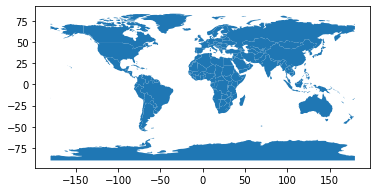

In [8]:
gdf.plot()
plt.show()

# Setting destinatio co-ord

In [9]:
df_target = pd.DataFrame(
    {'Country': 'UK' ,
     'Longitude': [2.85314 ],
     'Latitude': [53.91477]})

# Set target and origin centroids

In [10]:
gdf_uk = gpd.GeoDataFrame(
    df_target, geometry=gpd.points_from_xy(df_target.Longitude, df_target.Latitude),  crs={'init':'epsg:4326'})

C:\Python36\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
gdf_uk=pd.concat([gdf_uk]*178).reset_index()

In [12]:
gdf['target_UK']=gdf_uk['geometry']


In [13]:
gdf['centres']=gdf.geometry.centroid

In [14]:
gdf

,Country of origin,Refugees under UNHCR's mandate,alpha-3,region,sub-region,name,pop_est,geometry,iso_a3,target_UK,centres
0,Fiji,9.0,FJI,Oceania,Melanesia,Fiji,920938,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,POINT (2.85314 53.91477),POINT (163.85316 -17.31631)
1,"Tanzania, United Republic of",98.0,TZA,Africa,Sub-Saharan Africa,Tanzania,53950935,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,POINT (2.85314 53.91477),POINT (34.75299 -6.25773)
2,Western Sahara,12.0,ESH,Africa,Northern Africa,W. Sahara,603253,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",ESH,POINT (2.85314 53.91477),POINT (-12.13783 24.29117)
3,Canada,11.0,CAN,Americas,Northern America,Canada,35623680,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,POINT (2.85314 53.91477),POINT (-98.14238 61.46908)
4,United States of America,58.0,USA,Americas,Northern America,United States of America,326625791,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,POINT (2.85314 53.91477),POINT (-112.59944 45.70563)
...,...,...,...,...,...,...,...,...,...,...,...
173,North Macedonia,20.0,MKD,Europe,Southern Europe,Macedonia,2103721,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",MKD,POINT (2.85314 53.91477),POINT (21.69790 41.60593)
174,Serbia,86.0,SRB,Europe,Southern Europe,Serbia,7111024,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",SRB,POINT (2.85314 53.91477),POINT (20.81965 44.23304)
175,NaN,NaN,NaN,NaN,NaN,Montenegro,642550,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",MNE,POINT (2.85314 53.91477),POINT (19.28618 42.78904)
176,Trinidad and Tobago,89.0,TTO,Americas,Latin America and the Caribbean,Trinidad and Tobago,1218208,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",TTO,POINT (2.85314 53.91477),POINT (-61.33037 10.42824)


# Plot flows to and from centroids (start one to one)

In [15]:
gdf_subset=gdf[(gdf['name']=="United States of America") | (gdf['name']=="United Kingdom")]

In [16]:
gdf_subset

,Country of origin,Refugees under UNHCR's mandate,alpha-3,region,sub-region,name,pop_est,geometry,iso_a3,target_UK,centres
4,United States of America,58.0,USA,Americas,Northern America,United States of America,326625791,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,POINT (2.85314 53.91477),POINT (-112.59944 45.70563)
147,NaN,NaN,NaN,NaN,NaN,United Kingdom,64769452,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",GBR,POINT (2.85314 53.91477),POINT (-2.85314 53.91477)


In [17]:
def hanging_line(point1, point2):
    import numpy as np

    a = (point2[1] - point1[1])/(np.cosh(point2[0]) - np.cosh(point1[0]))
    b = point1[1] - a*np.cosh(point1[0])
    x = np.linspace(point1[0], point2[0], 100)
    y = a*np.cosh(x) + b

    return (x,y)

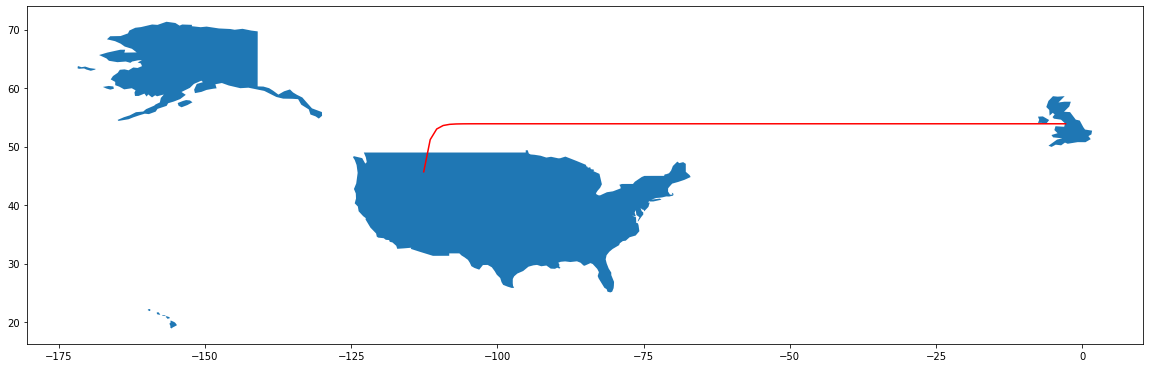

In [18]:
f,ax=plt.subplots(figsize=(20,20))

gdf_subset.plot(ax=ax)


point1=[gdf_subset.loc[147].centres.x,gdf_subset.loc[147].centres.y]
point2=[gdf_subset.loc[4].centres.x,gdf_subset.loc[4].centres.y]

x,y = hanging_line(point1, point2)

plt.plot(x,y, color='red')

# Plot flows all countries

In [19]:
gdf.columns

Index(['Country of origin', 'Refugees under UNHCR's mandate', 'alpha-3',
       'region', 'sub-region', 'name', 'pop_est', 'geometry', 'iso_a3',
       'target_UK', 'centres'],
      dtype='object')

C:\Python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


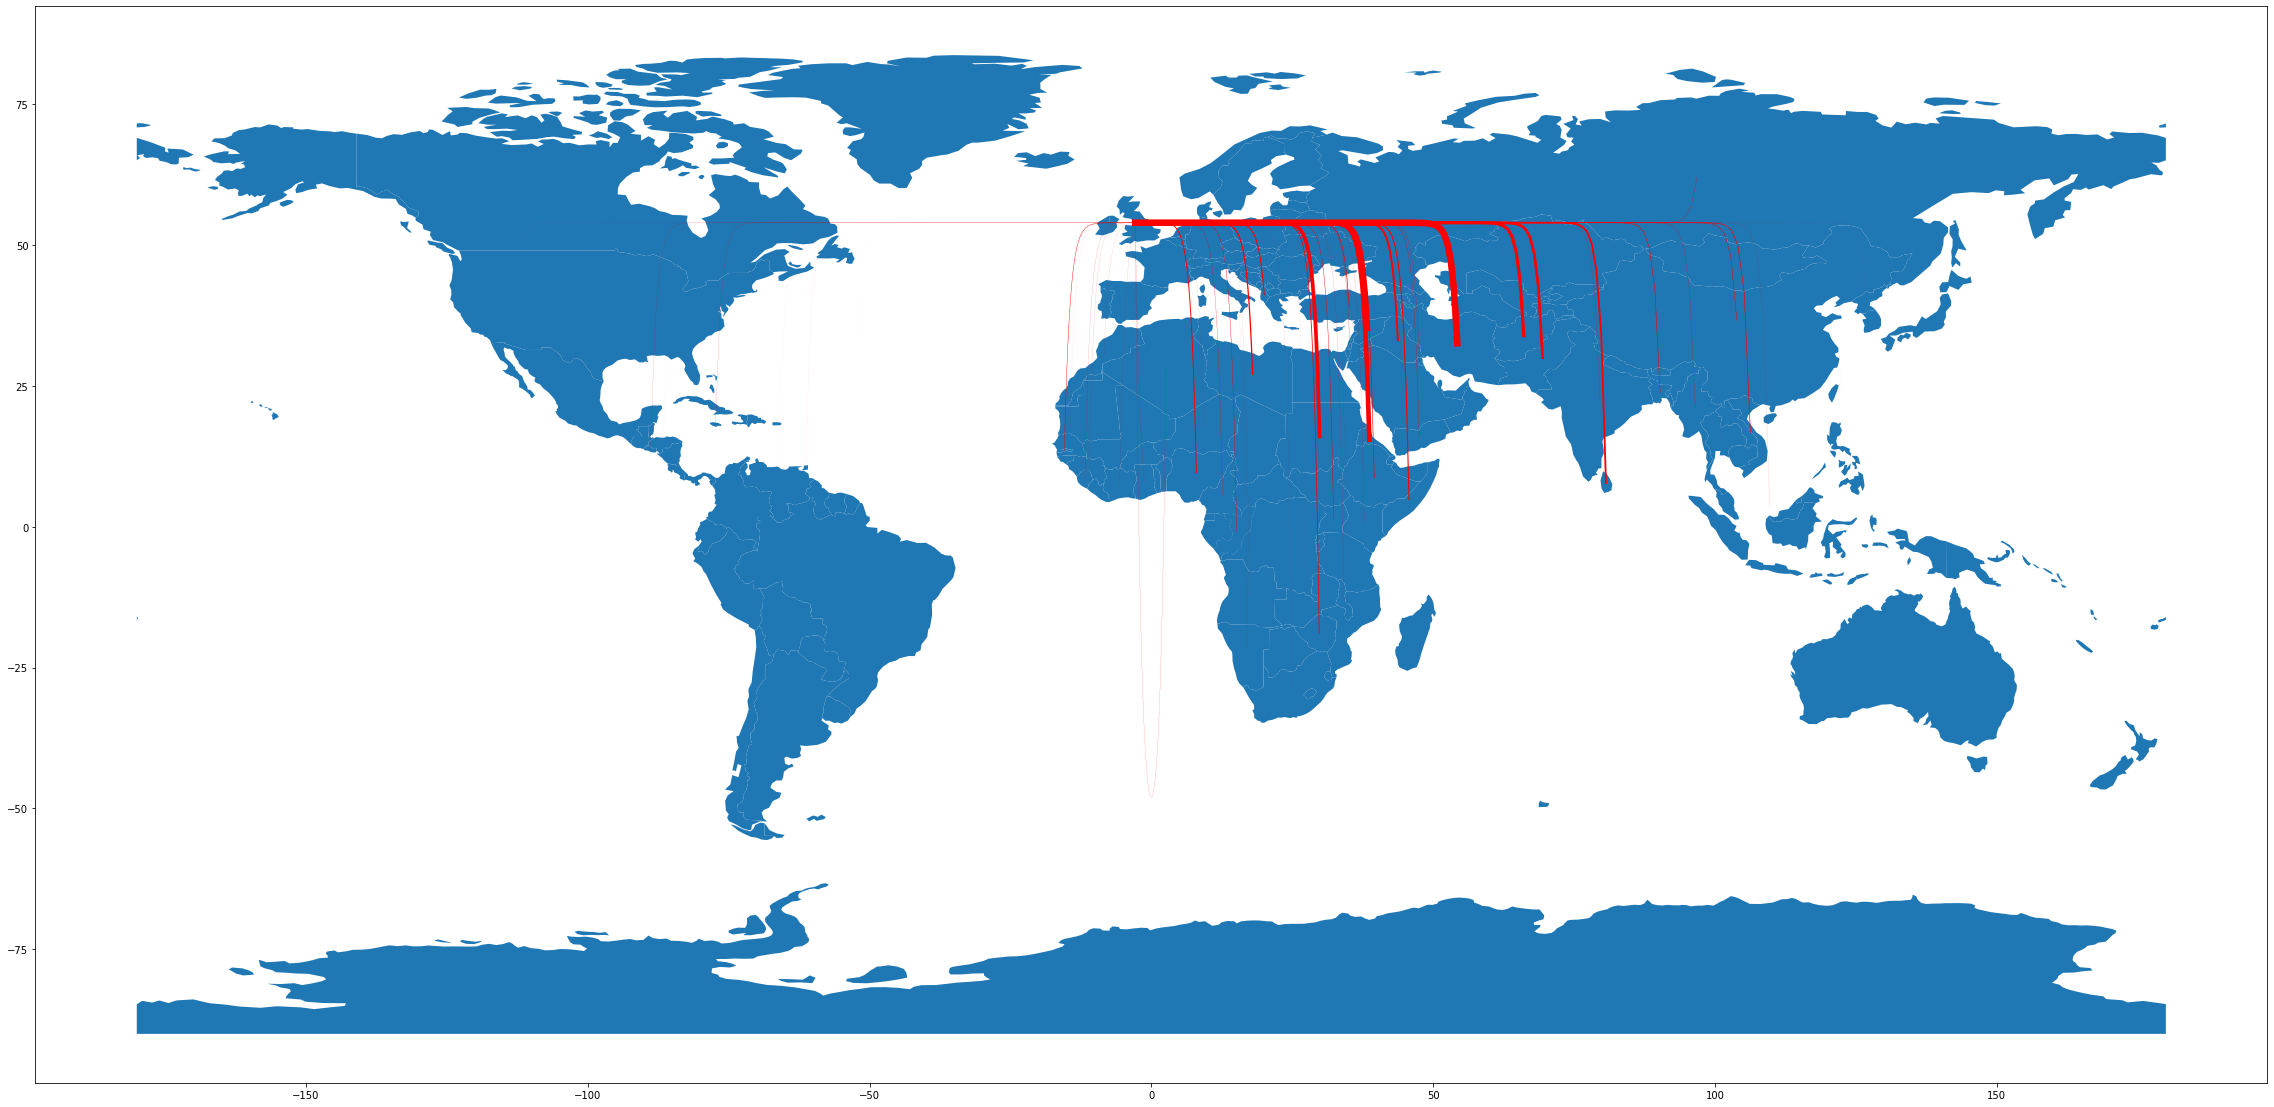

In [20]:
f,ax=plt.subplots(figsize=(40,40))

gdf.plot(ax=ax)



for i in range (1,177):
    point1=[gdf.loc[147].centres.x,gdf.loc[147].centres.y]
    point2=[gdf.loc[i].centres.x,gdf.loc[i].centres.y]
    
    x,y = hanging_line(point1, point2)
    plt.plot(x,y, color='red', linewidth=gdf.loc[i]["Refugees under UNHCR's mandate"]/3000)

In [21]:
gdf.to_csv("df_target_origin.csv")